In [1]:
skipFirstPart = True #set to true if previously read in your spotify data

In [2]:
# Importing spotipy which allows us to access Spotify API in python
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd

# Authentication - without user
# Client_id and client_secret come from app details on spotify for developers
client_credentials_manager = SpotifyClientCredentials(client_id='460984006c714f749850c9febc5fb84c',
                                                    client_secret='c4d508e3476c485983db321ab3bf36e7')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

if not skipFirstPart:
    # Importing all user data 

    from os import listdir

    # making an empty dataframe to store imported data
    data_import = pd.DataFrame()

    # storing name of path where data saved 
    path = 'streaming_data/'

    # iterating over all json files in folder and storing all data in same dataframe
    for file in listdir(path):
        read_data = pd.read_json(path + file)
        data_import = pd.concat([data_import, read_data])
        
        
    # Sort streaming data so latest played tracks are first in dataframe  
    data_import_sort = data_import.sort_values(by=['endTime'], ascending=False)

    # Reseting dataframe index to start at zero
    data_import_sort = data_import_sort.reset_index(drop=True)

    # Storing 500 of most recently played tracks 
    streaming_history_sample = data_import_sort.iloc[:500]


    # Querying spotify API for track and artist info

    # empty lists to store track feature data
    track_id_list = []
    artist_uri_list = []
    artist_name_track = []
    artist_pop_list = []
    artist_genre_list = []
    albums_list = []
    track_pop_list = []


    # iterating over each imported track name and artist name, searching spotify API for track and get information about track
    for artist_name, track_name in zip(streaming_history_sample['artistName'], streaming_history_sample['trackName']):
        
        # query API for track name using track and artist filters and store info
        track_information = sp.search(q= track_name + 'track:' + track_name + 'artist:' + artist_name, type='track')
        
        # if track information search was sucessful get track features
        if len(track_information['tracks']['items']) > 0:
            first_track_id = track_information['tracks']['items'][0]['id']
            artist_uri = track_information['tracks']['items'][0]['artists'][0]['uri']
            artist_name = track_information['tracks']['items'][0]['artists'][0]['name']
            artist_info = sp.artist(artist_uri)
            artist_pop = artist_info['popularity']
            artist_genre = artist_info['genres']  
            albums = track_information['tracks']['items'][0]['album']['name']
            track_pop = track_information['tracks']['items'][0]['popularity'] 
        
        # append info for track to feature data lists
            track_id_list.append(first_track_id)
            artist_name_track.append(artist_name)
            artist_pop_list.append(artist_pop)
            artist_genre_list.append(artist_genre)
            albums_list.append(albums)
            track_pop_list.append(track_pop)

    # if track information API search was unsuccessful store 'None' for features
        else:
            track_id_list.append('None')
            artist_name_track.append('None')
            artist_uri_list.append('None')
            artist_pop_list.append('None')
            artist_genre_list.append('None')
            albums_list.append('None')
            track_pop_list.append('None')
            
            
        


    # Storing track and artist info to a dataframe

    # List of track/artist features lists
    info_lists = [track_id_list, artist_name_track, artist_pop_list, albums_list, track_pop_list]
    track_info = pd.DataFrame()

    # Combining features to one dataframe
    for lists in info_lists:
        list_df= pd.DataFrame(lists)
        track_info = pd.concat([track_info, list_df], axis=1)
        
    track_info.columns= ['track_id', 'artist_name_track', 'artist_pop', 'album', 'track_pop']

    #track_info
    # Making dataframe of artist genre

    artist_genre_list_df = pd.DataFrame(artist_genre_list)

    # Making a list to store genre column name for dataframe
    genre_col_name = []
    length_genres = len(artist_genre_list_df.columns)

    # make a seperate column for each of the artist's genres
    for number in range(length_genres):
        column_name = 'genre_' + str(number) 
        genre_col_name.append(column_name)
    
    artist_genre_list_df.columns = genre_col_name

    # Combine genres to track info 
    track_info_genre = pd.concat([track_info, artist_genre_list_df], axis=1)
    track_info_genre_trackname = pd.concat([streaming_history_sample, track_info_genre], axis=1)
    #track_info_genre_trackname

    danceability = []
    energy = []
    loudness = []
    speechiness = []
    acousticness = []
    instrumentalness = []
    liveness = []
    valence = []
    tempo = []
    duration_ms = []
    time_signature = []

    for track_id in track_info_genre_trackname['track_id']:
        if track_id == 'None':
            danceability.append('None')       
            energy.append('None')
            loudness.append('None')
            speechiness.append('None')
            acousticness.append('None')
            instrumentalness.append('None')
            liveness.append('None')
            valence.append('None')
            tempo.append('None')
            duration_ms.append('None')
            time_signature.append('None')
            
        else:
            track_features = sp.audio_features(track_id)
            danceability.append(track_features[0]['danceability'])
            energy.append(track_features[0]['energy'])
            loudness.append(track_features[0]['loudness'])
            speechiness.append(track_features[0]['speechiness'])
            acousticness.append(track_features[0]['acousticness'])
            instrumentalness.append(track_features[0]['instrumentalness'])
            liveness.append(track_features[0]['liveness'])
            valence.append(track_features[0]['valence'])
            tempo.append(track_features[0]['tempo'])
            duration_ms.append(track_features[0]['duration_ms'])
            time_signature.append(track_features[0]['time_signature'])
        


    # Storing track features to dataframe

    # List of features
    feature_lists = [danceability, energy, loudness, speechiness, acousticness,
                    instrumentalness, liveness, valence, tempo, duration_ms, time_signature]
    feature_df = pd.DataFrame()

    # Combining features to one dataframe
    for lists in feature_lists:
        feature = pd.DataFrame(lists)
        feature_df = pd.concat([feature_df, feature], axis=1)
    
    feature_df.columns= ['danceability', 'energy', 'loudness', 'speechiness',
                        'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                        'duration_ms', 'time_signature']

    #feature_df
    # Combining track features with all other track and artist info
    all_track_information = pd.concat([track_info_genre_trackname, feature_df], axis=1)
    pd.options.display.max_columns = None


    #all_track_information
    streaming_history_track_info = all_track_information 

    #write to csv to not have to query the API each time. Can run from below this cell instead
    streaming_history_track_info.to_csv("StreamingHistoryWithTrackInfo.csv")

In [3]:
if skipFirstPart:
    streaming_history_track_info = pd.read_csv("StreamingHistoryWithTrackInfo.csv", index_col=[0])

In [4]:
# Importing streaming history with track feature dataset

# Spotify API search for track information and features was not perfect so we need to remove
# innaccurate results. This is done by checking the original artist name from the streaming history
# information dowloaded from spotify and comparing to the artist name retrieved from the API search.
# If the artist name from both sources do not match the code below removes the innaccurate data.

removed_artist_mismatch = streaming_history_track_info
count = 0

for originalName, searchedName in zip(streaming_history_track_info['artistName'], streaming_history_track_info['artist_name_track']):
    if originalName != searchedName:
        removed_artist_mismatch= removed_artist_mismatch.drop([count])
    count += 1

removed_artist_mismatch = removed_artist_mismatch.reset_index(drop=True)

removed_artist_mismatch.to_csv('user_info_cleaned.csv') 

In [5]:
user_track_data = pd.read_csv("user_info_cleaned.csv", index_col=0)
user_track_data

,endTime,artistName,trackName,msPlayed,track_id,artist_name_track,artist_pop,album,track_pop,genre_0,...,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2023-03-18 23:59,Dance Fruits Music,"Calabria (feat. Fallen Roses, Lujavo & Lunis) ...",156190,6MKuYvesr8p8csU9jt5Roa,Dance Fruits Music,73,Dance Fruits Music,64,lo-fi product,...,0.904,-3.408,0.0640,0.01530,0.550000,0.0963,0.372,124.020,128500,4
1,2023-03-18 23:57,Dance Fruits Music,Hello,158181,2uV2Jnqoa5oRnoGfNt19SP,Dance Fruits Music,73,Black Beatles,53,lo-fi product,...,0.794,-7.247,0.0586,0.08100,0.000017,0.0681,0.494,125.022,140225,4
2,2023-03-18 23:29,Dance Fruits Music,Better Off Alone,155559,4yKN43pgKLGsoGZWpHpW5A,Dance Fruits Music,73,Better Off Alone,60,lo-fi product,...,0.954,-3.751,0.0402,0.00142,0.243000,0.2390,0.266,131.964,155559,4
3,2023-03-18 23:26,Alesso,When I’m Gone (with Katy Perry),161266,5902W4uHWzhtOff1UK7the,Alesso,75,When I’m Gone (with Katy Perry),78,dance pop,...,0.886,-4.179,0.0340,0.02800,0.000000,0.4810,0.615,125.034,161267,4
4,2023-03-18 23:24,Tiësto,Don't Be Shy,140500,0bI7K9Becu2dtXK1Q3cZNB,Tiësto,84,Don't Be Shy,80,big room,...,0.787,-3.748,0.0583,0.19800,0.000000,0.2620,0.513,119.986,140500,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,2023-03-10 17:30,Dance Fruits Music,SUMMER JAM,1040,6FhhABinxDtRNKsicIv1EF,Dance Fruits Music,73,SUMMER JAM,54,lo-fi product,...,0.896,-6.446,0.0439,0.09890,0.000005,0.4230,0.202,125.020,142080,4
396,2023-03-10 17:30,Dance Fruits Music,The Rhythm Of The Night,1150,46tcH6oyF61incTXuv4eHm,Dance Fruits Music,73,Dance Fruits Music,48,lo-fi product,...,0.967,-3.145,0.0791,0.00407,0.675000,0.0859,0.391,126.969,148062,4
397,2023-03-10 17:30,Alesso,When I’m Gone (with Katy Perry),1040,5902W4uHWzhtOff1UK7the,Alesso,75,When I’m Gone (with Katy Perry),78,dance pop,...,0.886,-4.179,0.0340,0.02800,0.000000,0.4810,0.615,125.034,161267,4
398,2023-03-10 17:30,ATB,Your Love (9PM),18021,5YaskwnGDZFDRipaqzbwQx,ATB,64,Your Love (9PM),79,german dance,...,0.784,-5.603,0.1120,0.19400,0.000006,0.1150,0.517,125.993,150053,4


In [6]:
# Count identical values in Column1
counts = user_track_data['trackName'].value_counts()
artist_counts = user_track_data['artistName'].value_counts()

# Making a new dataframe deleting duplicated artist names and sorting by artist popularity scores
popularity_score_artist = user_track_data.drop_duplicates(subset='artistName')
popularity_score_artist = popularity_score_artist.sort_values(['artist_pop'], ascending=False).reset_index()


# Create a new dataframe with unique values and their counts
popular_tracks = pd.DataFrame({'trackName': counts.index, 'Count': counts.values})
popular_artists = pd.DataFrame({'artistName': artist_counts.index, 'Count': artist_counts.values})

# Sort the dataframe by count in descending order
popular_tracks = popular_tracks.sort_values(by='Count', ascending=False)
popular_artists = popular_artists.sort_values(by='Count', ascending=False)


In [7]:
# Saving most frequent tracks and artists to separate dataframe (top 20)
top_20_track = popular_tracks.iloc[0:20,]
top_20_artists = popular_artists.iloc[0:20,]
# Save artists with highest and lowest popularity scores to dataframe
popularity_score_artist = pd.concat([popularity_score_artist.head(10), popularity_score_artist.tail(10)])

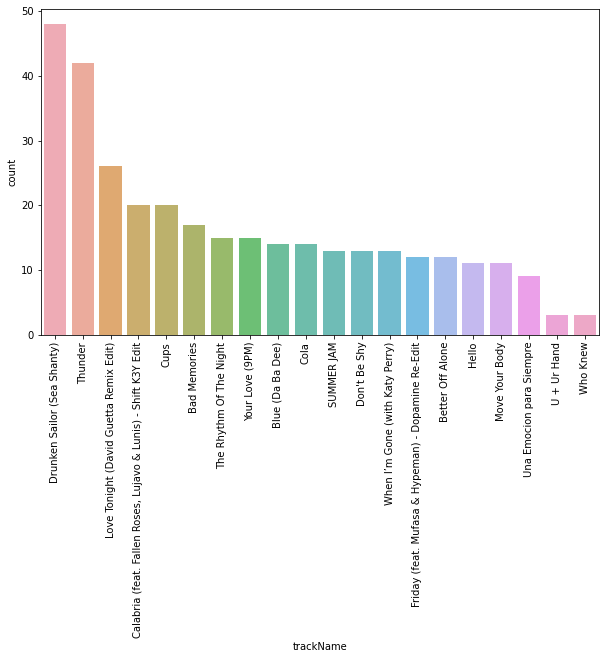

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10,6))
most_frequent_track = sns.countplot(x='trackName', alpha=0.8, data=user_track_data, order=pd.value_counts(user_track_data['trackName']).iloc[0:20].index)
most_frequent_track.set_xticklabels(most_frequent_track.get_xticklabels(), rotation=90);

In [9]:
import plotly.express as px
#redo all graphs in plotly to add to dash
pFrequentTrack = px.bar(top_20_track, x="trackName", y="Count", width=1200, height=800)
pFrequentTrack.update_layout(xaxis={'categoryorder':'total descending'})

pFrequentTrack

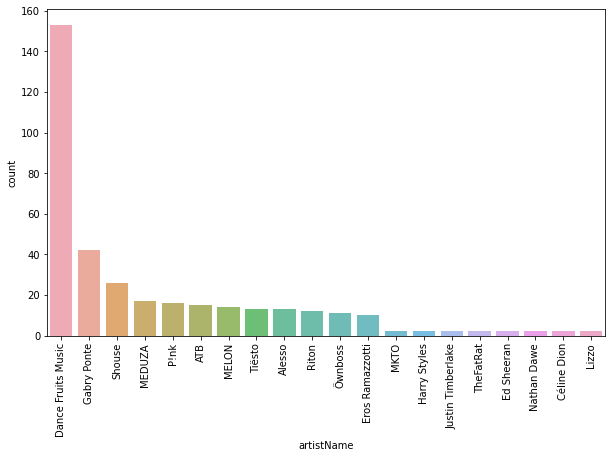

In [10]:
plt.figure(figsize=(10,6))
most_frequent_artist = sns.countplot(x='artistName', alpha=0.8, data=user_track_data, order=pd.value_counts(user_track_data['artistName']).iloc[:20].index)
most_frequent_artist.set_xticklabels(most_frequent_artist.get_xticklabels(), rotation=90);

In [11]:
pFrequentArtist = px.bar(top_20_artists, x="artistName", y="Count", width=1200, height=800)
pFrequentArtist.update_layout(xaxis={'categoryorder':'total descending'})

pFrequentArtist

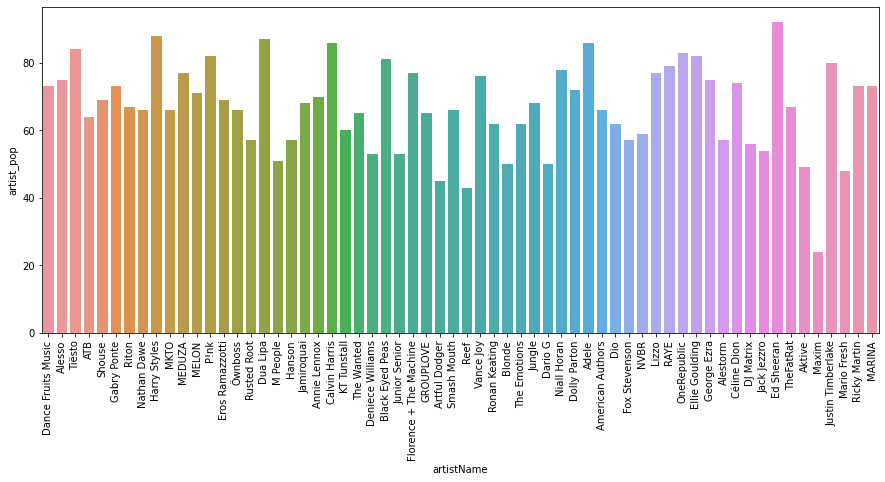

In [12]:
plt.figure(figsize=(15,6))
artist_popularity = sns.barplot(x=user_track_data['artistName'], y=user_track_data['artist_pop'])
artist_popularity.set_xticklabels(artist_popularity.get_xticklabels(), rotation=90);
# Order

In [13]:
pArtistPop = px.bar(popularity_score_artist, x="artistName", y="artist_pop", width=1200, height=800, color="artist_pop")
pArtistPop.update_layout(xaxis={'categoryorder':'total descending'})

pArtistPop

In [14]:
user_track_data.columns

Index(['endTime', 'artistName', 'trackName', 'msPlayed', 'track_id',
       'artist_name_track', 'artist_pop', 'album', 'track_pop', 'genre_0',
       'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6',
       'genre_7', 'genre_8', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')

In [15]:
import plotly.express as px

feature_1 = None
feature_2 = None
features = ['danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature']
flag_1 = 0
flag_2= 0

print(f"The dance features are: {features}")

while flag_1 < 1:
    feature_1 = "energy" #input("Please enter a feature for the x axis from the list above:").lower() 
    for feature in features:
            if feature == feature_1:
                flag_1 += 1
                break
                
while flag_2 < 1:
    feature_2 = "energy" #input("Please enter a feature for the y axis from the list above:").lower() 
    for feature in features:
            if feature == feature_2:
                flag_2 += 1
                break
                
def plot_maker(feature1, feature2):
    if(feature1 != None):
        if(feature2 != None):
            customFig = px.scatter(user_track_data, x=feature_1, y=feature_2,  color="genre_0", hover_data=['trackName'], width= 1200, height= 800)
            #customFig.show()
            return customFig

customFig = plot_maker(feature_1, feature_2)  
                

The dance features are: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']


In [16]:
import requests
from PIL import Image
from io import BytesIO

def getImage(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

In [17]:
# Count identical values in Column1
counts = user_track_data['trackName'].value_counts()

# Create a new dataframe with unique values and their counts
popular_tracks = pd.DataFrame({'trackName': counts.index, 'Count': counts.values})

# Sort the dataframe by count in descending order
popular_tracks = popular_tracks.sort_values(by='Count', ascending=False)

# Print the resulting dataframe
print('Your most popular track in the last 500 is ' + str(popular_tracks.iloc[0,0]))
print('You have so far listened to it ' + str(popular_tracks.iloc[0,1]) + ' times!')

popular_tracks = popular_tracks.reset_index()
user = user_track_data.merge(popular_tracks, on='trackName')
#for the top feature scores, only the features for the songs played 4 times or more were considered
user = user[user['Count']>=4]
user.tail()
user = user[['endTime', 'artistName', 'trackName', 'msPlayed', 'track_id','artist_name_track', 'artist_pop', 'album', 'track_pop', 'genre_0','danceability', 'energy', 'loudness','speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'index', 'Count']]
for column in user.columns:
    print('The max value for column ' + str(column) + ' is: ')
    (column) = user[column].max()
    print((column))
    print(' ')



Your most popular track in the last 500 is Drunken Sailor (Sea Shanty)
You have so far listened to it 48 times!
The max value for column endTime is: 
2023-03-18 23:59
 
The max value for column artistName is: 
Öwnboss
 
The max value for column trackName is: 
Your Love (9PM)
 
The max value for column msPlayed is: 
317222
 
The max value for column track_id is: 
7nkkmnKIm0ENXaAAw0Bq6J
 
The max value for column artist_name_track is: 
Öwnboss
 
The max value for column artist_pop is: 
84
 
The max value for column album is: 
Your Love (9PM)
 
The max value for column track_pop is: 
86
 
The max value for column genre_0 is: 
pop dance
 
The max value for column danceability is: 
0.848
 
The max value for column energy is: 
0.967
 
The max value for column loudness is: 
-3.145
 
The max value for column speechiness is: 
0.126
 
The max value for column acousticness is: 
0.198
 
The max value for column instrumentalness is: 
0.675
 
The max value for column liveness is: 
0.481
 
The max va

Song with most miliseconds played:
artistName    Gabry Ponte
trackName         Thunder
Name: 0, dtype: object


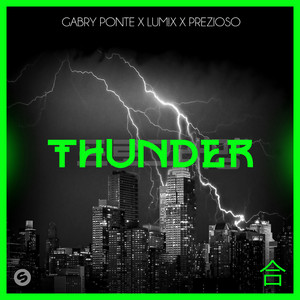

 
Song with highest popularity score:
artistName          Tiësto
trackName     Don't Be Shy
Name: 0, dtype: object


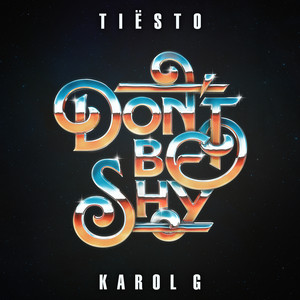

 
Song belonging to the most popular genre:
artistName          MEDUZA
trackName     Bad Memories
Name: 0, dtype: object


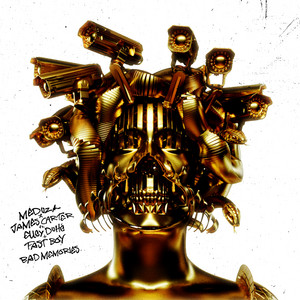

 
Song with highest danceability score:
artistName           Öwnboss
trackName     Move Your Body
Name: 0, dtype: object


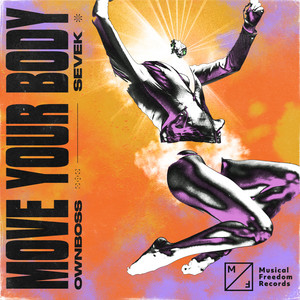

 
Song with highest energy score:
artistName         Dance Fruits Music
trackName     The Rhythm Of The Night
Name: 0, dtype: object


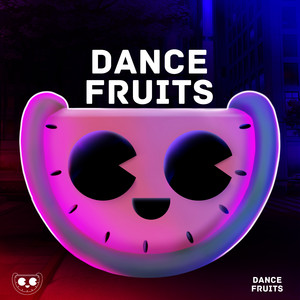

 
Song with highest loudness score:
artistName         Dance Fruits Music
trackName     The Rhythm Of The Night
Name: 0, dtype: object


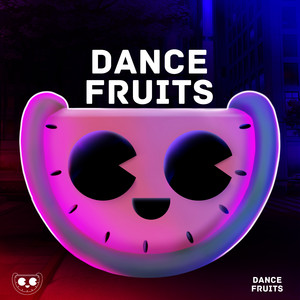

 
Song with highest speechiness score:
artistName                                                Riton
trackName     Friday (feat. Mufasa & Hypeman) - Dopamine Re-...
Name: 0, dtype: object


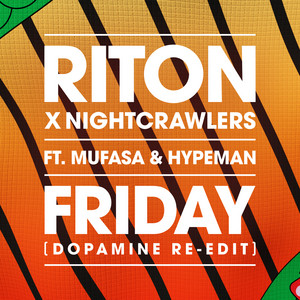

 
Song with highest acousticness score:
artistName          Tiësto
trackName     Don't Be Shy
Name: 0, dtype: object


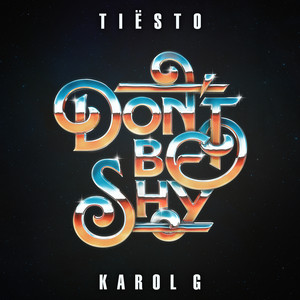

 
Song with highest instrumentalness score:
artistName         Dance Fruits Music
trackName     The Rhythm Of The Night
Name: 0, dtype: object


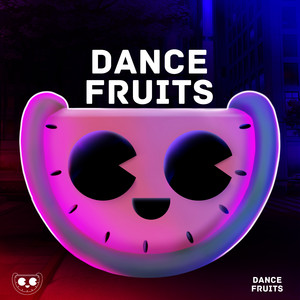

 
Song with highest liveness score:
artistName                             Alesso
trackName     When I’m Gone (with Katy Perry)
Name: 0, dtype: object


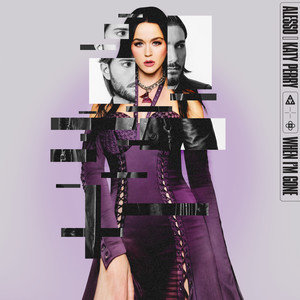

 
Song with highest valence score:
artistName             Eros Ramazzotti
trackName     Una Emocion para Siempre
Name: 0, dtype: object


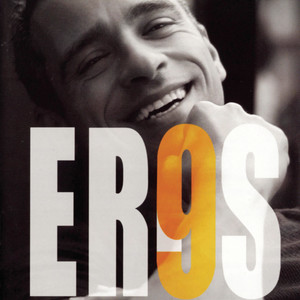

 
Song with highest tempo score:
artistName    Dance Fruits Music
trackName       Better Off Alone
Name: 0, dtype: object


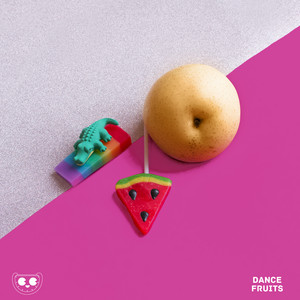

 
Song with highest duration score:
artistName                                    Shouse
trackName     Love Tonight (David Guetta Remix Edit)
Name: 0, dtype: object


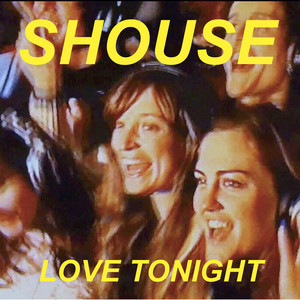

In [18]:
#add below code to html file to add to dashboard too:
with open("file.html", "a") as f:
    f.truncate(0)

    #Song with most miliseconds played
    print('Song with most miliseconds played:')
    f.write('Song with most miliseconds played:')
    msPlayed_max = user[user['msPlayed'] == user['msPlayed'].max()].reset_index()

    ms_played_track_info = sp.track(msPlayed_max['track_id'].values[0])
    ms_played_artwork_url = ms_played_track_info['album']['images'][1]['url']
    art1 = getImage(ms_played_artwork_url)

    print(msPlayed_max[['artistName', 'trackName']].iloc[0])
    #f.write(msPlayed_max[['artistName', 'trackName']].iloc[0])
    #f.write(display(art1))
    display(art1)
    print(' ')


    #Song with most popularity
    print('Song with highest popularity score:')
    artist_pop_max = user[user['artist_pop'] == user['artist_pop'].max()].reset_index()

    artist_pop_track_info = sp.track(artist_pop_max['track_id'].values[0])
    artist_pop_artwork_url = artist_pop_track_info['album']['images'][1]['url']
    art2 = getImage(artist_pop_artwork_url)

    print(artist_pop_max[['artistName', 'trackName']].iloc[0])
    display(art2)
    print(' ')


    #Song with most popular genre
    print('Song belonging to the most popular genre:')
    genre_max = user[user['genre_0'] == user['genre_0'].max()].reset_index()

    genre_track_info = sp.track(genre_max['track_id'].values[0])
    genre_artwork_url = genre_track_info['album']['images'][1]['url']
    art3 = getImage(genre_artwork_url)

    print(genre_max[['artistName', 'trackName']].iloc[0])
    display(art3)

    print(' ')


    #Song with most danceability
    print('Song with highest danceability score:')
    danceability_max = user[user['danceability'] == user['danceability'].max()].reset_index()

    danceability_track_info = sp.track(danceability_max['track_id'].values[0])
    danceability_artwork_url = danceability_track_info['album']['images'][1]['url']
    art4 = getImage(danceability_artwork_url)

    print(danceability_max[['artistName', 'trackName']].iloc[0])
    display(art4)

    print(' ')


    #Song with highest energy
    print('Song with highest energy score:')
    energy_max = user[user['energy'] == user['energy'].max()].reset_index()

    energy_track_info = sp.track(energy_max['track_id'].values[0])
    energy_artwork_url = energy_track_info['album']['images'][1]['url']
    art5 = getImage(energy_artwork_url)


    print(energy_max[['artistName', 'trackName']].iloc[0])
    display(art5)

    print(' ')


    #Song with highest loudness
    print('Song with highest loudness score:')
    loudness_max = user[user['loudness'] == user['loudness'].max()].reset_index()

    loudness_track_info = sp.track(loudness_max['track_id'].values[0])
    loudness_artwork_url = loudness_track_info['album']['images'][1]['url']
    art6 = getImage(loudness_artwork_url)

    print(loudness_max[['artistName', 'trackName']].iloc[0])
    display(art6)

    print(' ')


    #Song with highest speechiness
    print('Song with highest speechiness score:')
    speechiness_max = user[user['speechiness'] == user['speechiness'].max()].reset_index()

    speechiness_track_info = sp.track(speechiness_max['track_id'].values[0])
    speechiness_artwork_url = speechiness_track_info['album']['images'][1]['url']
    art7 = getImage(speechiness_artwork_url)

    print(speechiness_max[['artistName', 'trackName']].iloc[0])
    display(art7)

    print(' ')


    #Song with highest acousticness
    print('Song with highest acousticness score:')
    acousticness_max = user[user['acousticness'] == user['acousticness'].max()].reset_index()

    acousticness_track_info = sp.track(acousticness_max['track_id'].values[0])
    acousticness_artwork_url = acousticness_track_info['album']['images'][1]['url']
    art8 = getImage(acousticness_artwork_url)

    print(acousticness_max[['artistName', 'trackName']].iloc[0])
    display(art8)

    print(' ')


    #Song with highest instrumentalness
    print('Song with highest instrumentalness score:')
    instrumentalness_max = user[user['instrumentalness'] == user['instrumentalness'].max()].reset_index()

    instrumentalness_track_info = sp.track(instrumentalness_max['track_id'].values[0])
    instrumentalness_artwork_url = instrumentalness_track_info['album']['images'][1]['url']
    art9 = getImage(instrumentalness_artwork_url)

    print(instrumentalness_max[['artistName', 'trackName']].iloc[0])
    display(art9)

    print(' ')


    #Song with highest liveness
    print('Song with highest liveness score:')
    liveness_max = user[user['liveness'] == user['liveness'].max()].reset_index()

    liveness_track_info = sp.track(liveness_max['track_id'].values[0])
    liveness_artwork_url = liveness_track_info['album']['images'][1]['url']
    art10 = getImage(liveness_artwork_url)

    print(liveness_max[['artistName', 'trackName']].iloc[0])
    display(art10)

    print(' ')


    #Song with highest valence
    print('Song with highest valence score:')
    valence_max = user[user['valence'] == user['valence'].max()].reset_index()

    valence_track_info = sp.track(valence_max['track_id'].values[0])
    valence_artwork_url = valence_track_info['album']['images'][1]['url']
    art11 = getImage(valence_artwork_url)

    print(valence_max[['artistName', 'trackName']].iloc[0])
    display(art11)

    print(' ')


    #Song with highest tempo
    print('Song with highest tempo score:')
    tempo_max = user[user['tempo'] == user['tempo'].max()].reset_index()

    tempo_track_info = sp.track(tempo_max['track_id'].values[0])
    tempo_artwork_url = tempo_track_info['album']['images'][1]['url']
    art12 = getImage(tempo_artwork_url)

    print(tempo_max[['artistName', 'trackName']].iloc[0])
    display(art12)

    print(' ')


    #Song with highest duration
    print('Song with highest duration score:')
    duration_max = user[user['duration_ms'] == user['duration_ms'].max()].reset_index()

    duration_track_info = sp.track(duration_max['track_id'].values[0])
    duration_artwork_url = duration_track_info['album']['images'][1]['url']
    art13 = getImage(duration_artwork_url)

    print(duration_max[['artistName', 'trackName']].iloc[0])
    display(art13)

    print(' ')

In [19]:
def drop_for_sim_check(song):
    print(type(song))
    return song.drop(['endTime', 'msPlayed', 'track_id',
                    'artistName', 'artist_pop', 'trackName',
                    'album', 'track_pop', 'genre_0', 'artist_name_track',
                    'genre_1', 'genre_2', 'genre_3',
                    'genre_4', 'genre_5', 'genre_6',
                    'genre_7', 'genre_8', 'duration_ms'], axis=1)

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
bigDataset = pd.read_csv("musicdataset.csv")


# Takes the user input and searches the streaming history to check that the user has entered a correct
# track name. If they have not entered a track name that matches one in their streaming history
# they will again be asked to enter their chosen track.
# If they have entered correct track name, the track feature info of that track will be stored to separate
# dataframe.

user_selected_track_features = user_track_data
# Dataframe to store selected track features
print(user_selected_track_features)
large_dataset_similarity_features = bigDataset.drop(["uri", "key", "mode", "duration_ms", "chorus_hit", "sections", "popularity", "decade"], axis=1)

# Variable to store a number 1 if a correct track name has been entered
count = 0
# Variable to store index of track that's been compared to users input
index = 0


while count < 1:
    # ask for user input
    streaming_track_choice = input("Please enter the name of your chosen track:").lower() 
    # reset index to 0
    index = 0
    
    # For each track in streaming history, compare to user input
    for track in user_selected_track_features['trackName']:
        track_lower = track.lower() # change track name to all lower case characters
        
        if streaming_track_choice != track_lower: # if no match add one to index and try next track
            index += 1
            
            
        elif streaming_track_choice == track_lower: # if track name in streaming history matches user input
            print("Thank you, your selected track information has now been stored")
            user_selected_track_features = user_selected_track_features.iloc[[index]] # add info to dataframe
            count +=1 # add 1 to count to break out of while loop
            break # stop iterating over track names
   

user_selected_track_features = drop_for_sim_check(user_selected_track_features)

preparedSong1 = user_selected_track_features.iloc[0]
preparedSong1 = pd.DataFrame(preparedSong1).transpose()
songList = user_track_data["trackName"].unique() #for picking a song in the dashboard later



              endTime          artistName  \
0    2023-03-18 23:59  Dance Fruits Music   
1    2023-03-18 23:57  Dance Fruits Music   
2    2023-03-18 23:29  Dance Fruits Music   
3    2023-03-18 23:26              Alesso   
4    2023-03-18 23:24              Tiësto   
..                ...                 ...   
395  2023-03-10 17:30  Dance Fruits Music   
396  2023-03-10 17:30  Dance Fruits Music   
397  2023-03-10 17:30              Alesso   
398  2023-03-10 17:30                 ATB   
399  2023-03-10 17:30  Dance Fruits Music   

                                             trackName  msPlayed  \
0    Calabria (feat. Fallen Roses, Lujavo & Lunis) ...    156190   
1                                                Hello    158181   
2                                     Better Off Alone    155559   
3                      When I’m Gone (with Katy Perry)    161266   
4                                         Don't Be Shy    140500   
..                                                 

In [21]:
simVals = []
indexList = []
names = []
aname = []
similarityDF = pd.DataFrame()
songfeatures = preparedSong1.columns #for dropdowns later
for i in range(int(len(large_dataset_similarity_features))):
    song2 = large_dataset_similarity_features.iloc[i]
    sname = song2['track']
    artistname = song2['artist']
    song2 = song2.drop(["track", "artist"])
    song2 = song2.values.reshape(1,-1)

    sim = cosine_similarity(preparedSong1, song2)
    simVals.append(sim[0][0])
    indexList.append(i)
    names.append(sname)
    aname.append(artistname)


similarityDF["Similarity to target song"] = simVals
similarityDF["Song index"] = indexList
similarityDF["Track name"] = names
similarityDF["Artist name"] = aname

#TODO this could prolly be optimised

#TODO Error: bc the datasets that song1 and song2 are from are different, it's hard to directly compare them.
pd.set_option("display.precision", 12)
similarityDF = similarityDF.sort_values(by=["Similarity to target song"], ascending=False)
similarityDF.head(10)

,Similarity to target song,Song index,Track name,Artist name
34250,0.999997924581,34250,La La,Ashlee Simpson
36525,0.999997426144,36525,Levitate,Hadouken!
37666,0.999997341397,37666,Titanium,David Guetta Featuring Sia
36096,0.999997093263,36096,Heavy Metal Rules,Steel Panther
38540,0.999996804585,38540,Beautiful Lasers (2 Ways),Lupe Fiasco Featuring MDMA
29974,0.999996601796,29974,Pin-Up,Evans Blue
20510,0.999996599369,20510,Kick The Wall,Jimmy Davis & Junction
34182,0.999996524054,34182,Sorry,Buckcherry
24476,0.999996478118,24476,Lay All Your Love On Me,Helloween
33855,0.999996456280,33855,For The World To Dictate Our Death,Dimmu Borgir


In [22]:
import dash as dash
from dash import html
import dash_core_components as dcc
from dash.dependencies import Output, State, Input
import dash_table

C:\Users\krks347\AppData\Local\Temp\ipykernel_33272\1681973519.py:3: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

C:\Users\krks347\AppData\Local\Temp\ipykernel_33272\1681973519.py:5: UserWarning:


The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`



In [23]:
app = dash.Dash(__name__)
server = app.server
app.title="Spotify dashboard🎶"

In [24]:
@app.callback(
    Output('graphdiv', "children"),
    Input('param1', 'value'),
    Input('param2', 'value')
)
def drawCustomGraph(p1=None, p2=None, **kwargs): #defined further up but this makes it dcc for dashboard
    if(p1 != None):
        if(p2 != None):
            customFig = dcc.Graph(figure=px.scatter(user_track_data, x=p1, y=p2,  color="genre_0", hover_data=['trackName'], width= 1200, height= 800))
            #customFig.show()
            return customFig


In [25]:
# @app.callback(
#     Output('recommendiv', "children"),
#     Input('chosensong', 'value')
# )
# def doSimilarity(chosensong=user_track_data.iloc[0].trackName, **kwargs): #default to the first in your user data if not selected anything
#     songdata = user_track_data[user_track_data["trackName"] == chosensong]
#     preparedSong1 = drop_for_sim_check(songdata)
#     preparedSong1 = user_selected_track_features.iloc[0]
#     preparedSong1 = pd.DataFrame(preparedSong1).transpose()
    
#     simVals = []
#     indexList = []
#     names = []
#     aname = []
#     similarityDF = pd.DataFrame()

#     for i in range(int(len(large_dataset_similarity_features))):
#         song2 = large_dataset_similarity_features.iloc[i]
#         sname = song2['track']
#         artistname = song2['artist']
#         song2 = song2.drop(["track", "artist"])
#         song2 = song2.values.reshape(1,-1)

#         sim = cosine_similarity(preparedSong1, song2)
#         simVals.append(sim[0][0])
#         indexList.append(i)
#         names.append(sname)
#         aname.append(artistname)


#     similarityDF["Similarity to target song"] = simVals
#     similarityDF["Song index"] = indexList
#     similarityDF["Track name"] = names
#     similarityDF["Artist name"] = aname


#     pd.set_option("display.precision", 12)
#     similarityDF = similarityDF.sort_values(by=["Similarity to target song"], ascending=False)

#     table = dash_table.DataTable(data=similarityDF, row_deletable=False)
#     return table

In [26]:
similarityDF = similarityDF.set_axis(range(len(similarityDF)))
strs = []
startat = 0
if str(similarityDF.iloc[0]["Track name"] == streaming_track_choice):
    startat=1
for i in range(startat, startat+5):
    r1 = str(similarityDF.iloc[i]['Track name'])
    r2 = " by "
    r3 = str(similarityDF.iloc[i]['Artist name'])
    st = r1 + r2 + r3
    strs.append(st)

bigstr = " | ".join(strs)
bigstr

'Levitate by Hadouken! | Titanium by David Guetta Featuring Sia | Heavy Metal Rules by Steel Panther | Beautiful Lasers (2 Ways) by Lupe Fiasco Featuring MDMA | Pin-Up by Evans Blue'

In [27]:

app.layout = html.Div(children=[
    html.H1('Spotify dashboard😎🥶👺'),
    html.Div(children=[
        html.P("Most frequently listened to tracks:", style={"fontSize": 26}),
        dcc.Graph(id="graph1", figure=pFrequentTrack),
        html.P("Most frequently listened to artists:", style={"fontSize": 26}),
        dcc.Graph(id="graph2", figure=pFrequentArtist),
        dcc.Dropdown([*songfeatures],id='param1'), #unpack each item in the songfeatures list as an argument with *
        dcc.Dropdown([*songfeatures],id='param2'),
        html.P("Custom characteristics figure:", style={"fontSize": 26})]),

    html.Div(id="graphdiv"),
    html.P(('Song recommendations for "', streaming_track_choice, '":'), style={"fontSize": 26}),
    dcc.Dropdown([*songList], id="chosensong"),
    html.P(bigstr),
    #html.Div(id="recommendiv"),

    html.Div(children=[
        html.P("Artist popularity chart:", style={"fontSize": 26}),
        dcc.Graph(id="graph4", figure=pArtistPop),

        
        html.H1("-----Song Awards-----"),
        #Song with most miliseconds played
        html.P('Song with most miliseconds played:'),
        html.P(msPlayed_max['artistName'].iloc[0] + " - " + msPlayed_max['trackName'].iloc[0]),
        html.Img(src=art1),
        html.P(' '),


        #Song with most popularity
        html.P('Song with highest popularity score:'),
        html.P(artist_pop_max['artistName'].iloc[0] + " - " + artist_pop_max['trackName'].iloc[0]),
        html.Img(src=art2),
        html.P(' '),


        #Song with most popular genre
        html.P('Song belonging to the most popular genre:'),
        html.P(genre_max['artistName'].iloc[0] + " - " + genre_max['trackName'].iloc[0]),
        html.Img(src=art3),
        html.P(' '),


        #Song with most danceability
        html.P('Song with highest danceability score:'),
        html.P(danceability_max['artistName'].iloc[0] + " - " + danceability_max['trackName'].iloc[0]),
        html.Img(src=art4),
        html.P(' '),


        #Song with highest energy
        html.P('Song with highest energy score:'),
        html.P(energy_max['artistName'].iloc[0] + " - " + energy_max['trackName'].iloc[0]),
        html.Img(src=art5),
        html.P(' '),


        #Song with highest loudness
        html.P('Song with highest loudness score:'),
        html.P(loudness_max['artistName'].iloc[0] + " - " + loudness_max['trackName'].iloc[0]),
        html.Img(src=art6),
        html.P(' '),


        #Song with highest speechiness
        html.P('Song with highest speechiness score:'),
        html.P(speechiness_max['artistName'].iloc[0] + " - " + speechiness_max['trackName'].iloc[0]),
        html.Img(src=art7),
        html.P(' '),


        #Song with highest acousticness
        html.P('Song with highest acousticness score:'),
        html.P(acousticness_max['artistName'].iloc[0] + " - " + acousticness_max['trackName'].iloc[0]),
        html.Img(src=art8),
        html.P(' '),


        #Song with highest instrumentalness
        html.P('Song with highest instrumentalness score:'),
        html.P(instrumentalness_max['artistName'].iloc[0] + " - " + instrumentalness_max['trackName'].iloc[0]),
        html.Img(src=art9),
        html.P(' '),


        #Song with highest liveness
        html.P('Song with highest liveness score:'),
        html.P(liveness_max['artistName'].iloc[0] + " - " + liveness_max['trackName'].iloc[0]),
        html.Img(src=art10),
        html.P(' '),


        #Song with highest valence
        html.P('Song with highest valence score:'),
        html.P(valence_max['artistName'].iloc[0] + " - " + valence_max['trackName'].iloc[0]),
        html.Img(src=art11),
        html.P(' '),


        #Song with highest tempo
        html.P('Song with highest tempo score:'),
        html.P(tempo_max['artistName'].iloc[0] + " - " + tempo_max['trackName'].iloc[0]),
        html.Img(src=art12),
        html.P(' '),


        #Song with highest duration
        html.P('Song with highest duration:'),
        html.P(duration_max['artistName'].iloc[0] + " - " + duration_max['trackName'].iloc[0]),
        html.Img(src=art13),
        html.P(' '),

        html.P(' ')
    ])
])



#layout code courtesy of https://dash.plotly.com/dash-html-components

if(__name__ == "__main__"):
    app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
